# Mini-Projet `MNIST`
Auteurs: *Emilie GALLAND*, *Léo BRENDLE*, *Fouad AFANE*


Le dataset `MNIST` est un incoutournable du machine learning. Ce problème de classification de chiffres écrits à la main a joué un rôle historique important (lecture automatique des codes postaux aux Etats-Unis). Il a donné lieu à de nombreuses études comparatives. On pourra consulter par exemple [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/)

**Conseils:**
- on trouve sur internet de nombreuses études de ce jeux de données classiques; on pourra bien sûr s’en inspirer, mais tout copié-collé abusif est proscrit et sera sanctionné, de même que le recours abusif à l'IA ou la copie entre binômes.
- la rédaction (description de la méthodologie) et l'interprétation des résultats rentreront fortement en compte dans l'évaluation.

In [6]:
# chargement des librairies et des données
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

col_names = ['Y'] + [f'X{i}' for i in range(1, 785)]
mnist_train = pd.read_csv("mnist_train.csv", sep=",", names=col_names, header=None)
mnist_test = pd.read_csv("mnist_test.csv", sep=",", names=col_names, header=None)
mnist_train['Y'] = mnist_train['Y'].astype('category')
mnist_test['Y'] = mnist_test['Y'].astype('category')

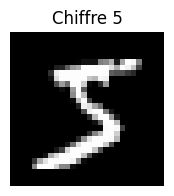

In [7]:
# affichage de la premiere ligne sous forme d'image et label

M = mnist_train.iloc[0, 1:].to_numpy()   # vecteur de 784 pixels
M = M.reshape((28, 28))                  # transformation en matrice 28x28
plt.figure(figsize=(2,2))
plt.imshow(M, cmap="gray", interpolation="nearest")
plt.title(f"Chiffre {mnist_train.iloc[0, 0]}")
plt.axis("off")
plt.show()

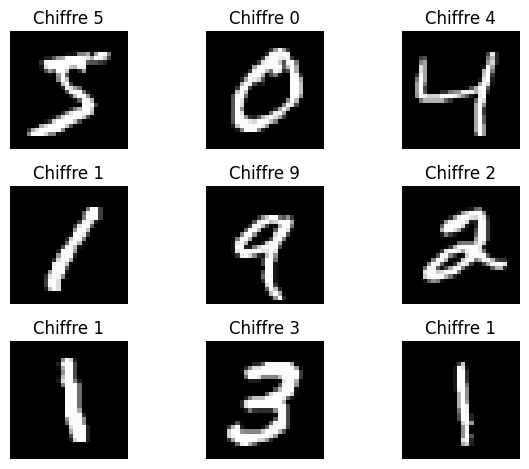

In [8]:
# affichage des 9 premieres ligne sous forme d'image et label

for i in range(9):
    # Extraction de l'image
    M = mnist_train.iloc[i, 1:].to_numpy().reshape((28, 28))
 
    # Ajout du subplot
    plt.subplot(3, 3, i + 1)
    plt.imshow(M, cmap="gray", interpolation="nearest")
    plt.title(f"Chiffre {mnist_train.iloc[i, 0]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Tâches à effectuer
Comparer les différentes méthodes vues en cours sur le jeu de données `MNIST`. On entrainera les méthodes sur l'échantillon train et évaluera leur performance sur l'échantillon test. Lorsque cela sera pertinent, on ajustera les hyperparamètres de la méthode par validation croisée à 10 couches sur l'échantillon train. Dans cette tâche de classification multitype à 10 classes, on pourra utiliser directement un classifieur multitype ou bien un classifieur binaire avec une approche  One Versus All.
On pourra s'inspirer du plan de travail suivant, sans que cela ne soit restrictif.

**Plan de travail**
1. Décrire les jeu de données. En particulier nombre d'exemples en apprentissage et en test; proportion de chaque classe dans les deux échantillons.
2. Appliquer la méthode des k plus proches voisins après centrage et réduction des données.
3. Appliquer la méthode de régression logistique.
4. Appliquer la méthode d'analyse discriminante linéaire.
5. Appliquer la méthode Random Forest en optimisant `max_features`.
6. Appliquer la méthode Support Vector Machine avec noyau gaussien en optimisant `gamma`.
7. Appliquer l'algorithme XGBoost (charger la librairie) ou bien l'algorithme Gradient Boosting de scikitlearn.
8. Représenter sur un graphique le taux d'erreur pour chacune des méthodes et commenter.éthodes et conclusions

## Jeu de données

Le jeu de données MNIST (Modified National Institute of Standards and Technology) est une grande base d'images représentant des chiffres écrits à la main. Il est souvent utilisé en intelligence artificielle pour tester les performances de modèles, pour des tâches comme le débruitage d'images ou la vision par ordinateur par exemple.

In [10]:
np.shape(mnist_train), np.shape(mnist_test)

((60000, 785), (10000, 785))

mnist_train est un data frame de taille 60000 $\times$ 785. Les variables sont des variables quantitatives avec Y la vraie valeur du chiffre écrit et les variables X, sont des variables qui représentent les intensités des pixels (entre 0 et 1, 0 : noir, 1 : blanc). Chaque ligne représente donc une image en noir et blanc au format 28x28 pixels, ainsi que le chiffre manuscrit qui est représenté.

De même mnist_test est un data frame de taille 10000 $\times$ 785. On a donc environ 14% des valeurs qui sont dans le jeu test afin d'évaluer la qualité des modèles entrainés sur mnist_train.

## Méthodes des k plus proches voisins

Dans cette partie, on souhaite appliquer la méthode des k plus proches voisins . \
Ce modèle prédit la classe majoritaire pour les k proches voisins, c'est à dire:
$
\hat{y} = \arg\max_{C} \operatorname{card}\left\{ i \mid Y_i = C,\, X_i \in N_k(x) \right\}
$.



In [9]:
#Méthode des k plus proches voisins

#on commence par centré et réduire les variables X
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(mnist_train.iloc[:,1:])
X_scaled_test = scaler.fit_transform(mnist_test.iloc[:,1:])
Y_train = mnist_train.iloc[:,0]
Y_test = mnist_test.iloc[:,0]

#On applique la méthode des K plus proches voisins avec une grille d'hyperparamètres
#param_grid = {'n_neighbors' : range(1,5)}
#models_knn = GridSearchCV(KNeighborsClassifier(), param_grid, n_jobs=-1).fit(X_scaled_train, Y_train)
#cv_results = pd.DataFrame(models_knn.cv_results_)
#cv_results.head()

## Modèles de régression logistique

On applique un modèle de régression logistique.
Le modèle peut s'écrire :  
$\hat{y} = \arg\max_{C} \mathbb{P}(Y = C \mid X)$

In [ ]:
#Modèles de régression logistique
model_reg_log = LogisticRegression(max_iter = 100, solver = 'newton-cg')
model_reg_log.fit(X_scaled_train, Y_train)
x0 = X_scaled_test[0,:].reshape(1,-1)
y0 = model_reg_log.predict(x0)
print(f"Le nombre prédit en x0 est y0 = {y0.item():.3f} or y = {Y_test[0]}")
y_pred = model_reg_log.predict(X_scaled_test)
err_test = mean_squared_error(y_pred, Y_test)

## Analyse discriminante linéaire

In [ ]:
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_scaled_train, Y_train)
print(f"Le nombre prédit en x0 est Y0 = {LDA.predict(x0)}")


## Random forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_scaled_train, Y_train)

## SVM

## XGboost

In [3]:
import sys
print(sys.executable)

/Users/leobrendle/Documents/Etudes/M2_stats/projet-python-M2-S1/.venv-1/bin/python


In [5]:
!{sys.executable} -m pip install --upgrade pip setuptools wheel
!{sys.executable} -m pip install -U scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.2 MB/s  0:00:00 eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 25.2
    Uninstalling pip-25.2:
      Successfully uninstalled pip-25.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pip]1/2 [pip]
  Using cached scikit_learn-1.7.2-cp312-cp312-macosx_10_13_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.16.2-cp312-cp312-macosx_14_0_x86_64.whl.metadata (62 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.2-cp312-cp312-macosx_10_13_x86_64.whl (9.3 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached scipy-1.16.2-cp312-cp312-macosx_14_0_x86_64.whl (23.6 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]
